In [15]:
%matplotlib notebook
%pylab
import pandas as pd

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
%reload_ext autoreload
%autoreload 2

# Wave propagation algorithm for constant coefficient advection
<hr style="border-width:4px; border-color:coral"></hr>

The one dimensional scalar advection equation considered here is 

\begin{equation}
q_t + A q_x = 0
\end{equation}

where $q(x,t) \in \mathcal R^{m}$ is a system of tracer quantities and $A \in \mathcal R^{m \times m}$ is a constant matrix. 

In the wave propagation algorithm, the update formula is given in terms of *waves*, *speeds* and *fluctuations*.  
\begin{equation}
Q_i^{n+1} = Q_i^{n} - \frac{\Delta t}{\Delta x}\left(\mathcal A^+ \Delta Q_{i-1/2}  + \mathcal A^- \Delta Q_{i+1/2}\right) - \frac{\Delta t}{\Delta x}\left(\mathcal F_{i-1/2} + \mathcal F_{i+1/2}\right)
\end{equation}

where integer indices are values at cell centers, and half indices are used to indicate values at cell interfaces.  

The *waves* are defined in terms of a eigenvalue/eigenvector decomposition of the matrix $A$.  Let $\lambda^p$, $p = 1,2,...,m$ be the eigenvalues of $A$, where we assume $\lambda_1 \le \lambda^2 \le ... \le \lambda^m$.  Let $\mathbf r^p$ be the eigenvector associated with the eigenvalue $\lambda^p$, and let $R$ be defined as 
the $m \times m$ matrix

\begin{equation}
R = \left[\mathbf r^1, \mathbf r^2, ..., \mathbf r^m\right]
\end{equation}

A system is *hyperbolic* if the matrix $R$ is invertible, and all of the eigenvalues are real.  To define the *waves*, we solve 

\begin{equation}
R \alpha_{i-1/2} = Q_{i} - Q_{i-1}
\end{equation}

for the vector $\alpha_{i-1/2}$.   The waves at interface $x_{i-1/2}$ are then defined as

\begin{equation}
\mathcal W^p_{i-1/2} \equiv \alpha^p_{i-1/2} \mathbf r^p
\end{equation}

The *speeds* at each interface are the eigenvalues and are given by $s^p \equiv \lambda^p$. 

The *fluctuations* $\mathcal A^{+} \Delta Q_{i-1/2}$ and $\mathcal A^{-} \Delta Q_{i+1/2}$ are defined in terms of the waves and speeds as 

\begin{eqnarray}
\mathcal A^{+} \Delta Q_{i-1/2} & \equiv & \sum_{p=1}^m (s^p)^{+} \mathcal W_{i-1/2}^p\\
\mathcal A^{-} \Delta Q_{i-1/2} & \equiv & \sum_{p=1}^m (s^p)^{-} \mathcal W_{i-1/2}^p\\
\end{eqnarray}

\begin{equation*}
(s^p)^+ \equiv \max(0,s^p) \qquad (s^p)^- \equiv \min(0,s^p)
\end{equation*}

The second order correction terms are given in terms of the waves and speeds at each interface as

\begin{equation*}
\mathcal F_{i-1/2} = \frac{1}{2}\sum_{p=1}^m |s^p|\left(1 - \frac{\Delta t}{\Delta x} |s^p| \right) \mathcal W^p_{i-1/2}
\end{equation*}

To reduce oscillations in the solution, waves are typically limited with a *wave limiter*.  

\begin{equation}
\widetilde{\mathcal W}_{i-1/2} = \theta \; \mathcal W_{i-1/2}
\end{equation}

where $\theta$ is a coefficient that typically depends on neighboring $Q$ values $Q_{i-2},Q_{i-1},Q_{i},Q_{i+1},Q_{i+2}$.


## Riemann solver
<hr style="border-width:4px; border-color:coral"></hr>

The waves, speeds and fluctuations are computed in a *Riemann solver*.  The solver below
assumes that $Q_i$, $i = 0,1,...,N-1$ has been extended by a layer of two ghost cells at each end of the domain. 

\begin{equation}
Q_{ext} = \left[\bar{Q}_{-2}, \bar{Q}_{-1}, Q, \bar{Q}_{N}, \bar{Q}_{mx+2}\right]
\end{equation}

where $\bar{Q}_i$ are determined using either periodic boundary conditions, an exact solution, or some other condition, depending on the problem being solved.  Boundary conditions are 
supplied in the user function described below.  

The output are the waves $\mathcal W^p_{i-1/2}$, speeds $s^p_{i-1/2}$, $p = 1,2,...,m$ and fluctations 
$\mathcal A^+ \Delta Q_{i-1/2}$ and $\mathcal A^- \Delta Q_{i-1/2}$ at cell interfaces
$i = -3/2, -1/2, ..., N-1/2, N+1/2$.  


The follow solver solves the $2 \times 2$ advection equation for two tracer quantities.  Here, we assume that the matrix $A$ is a $2 \times 2$ matrix with constant entries $a_{ij}$.  

\begin{equation}
A = \begin{bmatrix}
a_{11} & a_{13} \\ a_{21} & a_{22}
\end{bmatrix}
\end{equation}

The $2 \times 2$ matrix is user defined and can be provided in subsequent cells.

In [3]:
# Global data needed for Riemann solver and initialization routine


def rp1_adv_2x2(Q_ext):
    """  Input : 
            Q_ext : Array of N+4 Q values.   Boundary conditions are included.
            
        Output : 
            waves  : Jump in Q at edges -3/2, -1/2, ..., N-1/2, N+1/2 (N+3 values total)
            speeds : Array of speeds (N+3 values)
            apdq   : Positive fluctuations (N+3 values)
            amdq   : Negative fluctuations (N+3 values)
        """    
        
    # This Riemann solver solves the scalar advection problem q_t + A*q_x = 0
    # where A = u*eye(meqn). 
    
    assert meqn == 2, 'rp1_adv_2x2 : For this solver, you must set meqn == 2'
            
    # For most problems, the number of waves is equal to the number of equations
    mwaves = meqn
    
    # -------------------------------------------------------
    # Code here should be modified for each problem ---------
    # -------------------------------------------------------
    # Vectors of eigenvalues
    # Computed above

    # Compute jump in Q at each interface
    delta = Q_ext[1:,:]-Q_ext[:-1,:]
    
    d0 = delta[:,[0]]
    d1 = delta[:,[1]]
    
    # Compute charasteristic variables : alpha = R^{-1}*delta
    a0 = Rinv[0,0]*d0 + Rinv[0,1]*d1
    a1 = Rinv[1,0]*d0 + Rinv[1,1]*d1

    # Compute waves :  W^p = \alpha^p r^p
    w0 = a0@R[:,[0]].T
    w1 = a1@R[:,[1]].T
    
    # Compute speeds from eigenvalues : s^p = \lambda^p
    z = ones((delta.shape[0],1))
    s0 = evals[0]*z
    s1 = evals[1]*z
    
    # Construct tuples containing waves and speeds
    waves = (w0, w1)
    speeds = (s0, s1)
    
    
    # -------------------------------------------------------
    # ------------------------------- Modified code ends here
    # -------------------------------------------------------
    
                
    # Fluctuations
    amdq = zeros(delta.shape)
    apdq = zeros(delta.shape)
    for p in range(mwaves):
        sm = where(speeds[p] < 0, speeds[p], 0)
        amdq += sm*waves[p]
        
        sp = where(speeds[p] > 0, speeds[p], 0)
        apdq += sp*waves[p]
    
    return waves,speeds,amdq,apdq


## Problem definition : tracer advection
<hr style="border-width:4px; border-color:coral"></hr>

The matrix $A$ can be chosen below.  In order for the system to be hyberbolic, the matrix $A$ must be invertible, and must have a linearly independent set of eigenvectors.  

In [4]:
# Define 2x2 matrix A. 

# ----------------------------- Choose A ---------------------------------
# Hyperbolic : Both waves move at speed u
u = 2
A = array([[u,0],[0,u]])

# Hyperbolic : A is diagonizable
# A = array([[1,2],[3,-5]])

# Hyperbolic : A is diagonizable
# A = array([[1,2],[1,1]])

# Hyperbolic : A in singular, but is symmetric and so has a full set of eigenvalues. 
#A = array([[1,2],[2,4]])
# ------------------------------------------------------------------------


# Not hyperbolic : A is not diagonizable
# A = array([[1,1],[0,1]])   


# Check to make sure the eigenvalues are real
det_A = det(A)
tr = trace(A)

print("")
print("tr**2 - 4*det_A = ",tr**2 - 4*det_A)
assert tr**2 - 4*det_A >= 0, 'Eigenvalues are not real;  The system is not hyperbolic'

# Check to make sure A is diagonizable
evals,R = eig(A)

print("")
print("(l_1, v_1)")
print((evals[0],R[:,0]))

print("")
print("(l_2, v_2)")
print((evals[1],R[:,1]))

assert abs(det(R)) > 1e-14, 'A is not diagonizable.  The system is not hyperbolic'

# Umax needed to compute stable time step
umax = amax(abs(evals))

# Left eigenvectors needed to compute the true solution.
Rinv = solve(R,eye(2))


tr**2 - 4*det_A =  0.0

(l_1, v_1)
(2.0, array([1., 0.]))

(l_2, v_2)
(2.0, array([0., 1.]))


## Initial conditions and exact solution
<hr style="border-width:2px; border-color:black"></hr>

The exact solution $q(x,t)$ is given here. The initial condition is evaluated as the exact solution  at time $t=0$. 

The solver should supply an initialization routine to initialize $q(x,t)$ at time $t=0$.



In [5]:
def q0_init(x):
    if problem_choice in [0,1,2]:
        q0 = sin(2*pi*x)
    elif problem_choice == 3:
        q0 = where(x > 0.5, 1, 0)
        
    q0.shape = (x.shape[0],1)
    
    return q0

def q1_init(x):
    if problem_choice == 0:
        q1 = 0.1*cos(2*pi*x)
    elif problem_choice == 1:
        q1 = 0.4*cos(16*pi*x)
    elif problem_choice == 2:
        q1 = exp(-160*(x-0.5)**2)
    elif problem_choice == 3:
        q1 = where(x < 0.5, -1,0)
        
    q1.shape = (x.shape[0],1)
    
    return q1

# this relies on velocity u set above.
def qexact(x,t,meqn):
    u0 = evals[0]
    u1 = evals[1]
    
    W = zeros((x.shape[0],meqn))
    
    q0 = q0_init(mod(x-u0*t,1))
    q1 = q1_init(mod(x-u0*t,1))
    Q = concatenate((q0,q1),axis=1)    
    
    
    W[:,[0]] = Q@Rinv[[0],:].T  # Rows of Rinv are the left eigenvectors lp

    q0 = q0_init(mod(x-u1*t,1))
    q1 = q1_init(mod(x-u1*t,1))
    
    Q = concatenate((q0,q1),axis=1)    
    W[:,[1]] = Q@Rinv[[1],:].T  # Rows of Rinv are the left eigenvectors lp 
        
    qe = W@R.T
    
    return qe
        
def qinit(x,meqn):
        
    return qexact(x,0,meqn)
            


## Boundary conditions
<hr style="border-width:2px; border-color:black"></hr>

The boundary conditions can be determined in a variety of ways.  Below, we prescribe
periodic boundary conditions. 

In [6]:
def bc_periodic(Q):
    """ Extend Q with periodic boundary conditions """
        
    Q_ext = concatenate((Q[-2:,:], Q, Q[:2,:]))
    return Q_ext

def bc_extrap(Q):
    """ Extend Q with periodic boundary conditions """
        
    Q_ext = concatenate((Q[[1,0],:], Q, Q[[-1,-2],:]))
    return Q_ext

## Example
<hr style="border-width:4px; border-color:coral"></hr>

Below, we solve the scalar advection equation on the domain $[0,1]$ using periodic boundary conditions.  

In [7]:
# Spatial domain
ax = 0
bx = 1
meqn = 2  # Number of equations in the system

problem_choice = 1
riemann_solver = rp1_adv_2x2

bc_condition = bc_periodic

# Temporal domain
Tfinal = 1

# Numerical parameters
cfl = 0.5

## Sample test and plot
<hr style="border-width:2px; border-color:black"></hr>

Plot the solution at a specified resolution. 

In [9]:
import wpa

mx = 128
    
# Estimate time step and number of time steps to take
dx = (bx-ax)/mx
dt_est = cfl*dx/umax;
nout = int(floor(Tfinal/dt_est) + 1)
dt = Tfinal/nout
        
Q,xc,tvec, t_time,wall = wpa.claw1(ax,bx, mx,  Tfinal, nout, \
                      meqn=meqn, \
                      rp=riemann_solver, \
                      qinit=qinit, \
                      bc=bc_condition, \
                      limiter_choice='MC',
                      second_order=True)

## Plot the solution
<hr style="border-width:2px; border-color:black"></hr>


In [ ]:

fig = figure(1)
clf()

mq = 0  # Component to plot

assert mq <= meqn, 'mq must be less than or equal to meqn'

q0 = Q[:,mq,0]
hdl, = plot(xc,q0,'b.',markersize=5,label='Computed solution')

xfe = linspace(ax,bx,1000)
xfc = xfe[:-1] + dx/2
qe = qexact(xfc,0,meqn)
hdl_exact, = plot(xfc,qe[:,mq],'r-',label='Exact solution')

tstr = 'Wave Propagation : t = {:.4f}'
htitle = title(tstr.format(0),fontsize=18)

legend()

for i,t in enumerate(tvec):
    q = Q[:,mq,i]
    
    hdl.set_ydata(q)

    qe = qexact(xfc,t,meqn)
    
    hdl_exact.set_ydata(qe[:,mq])
    
    xlabel('x',fontsize=16)
    ylabel('q(x,t)',fontsize=16)
    htitle.set_text(tstr.format(t))
    
    ylim([-1.3,1.6])
    pause(0.1)

    fig.canvas.draw()
    


## Convergence study
<hr style="border-width:4px; border-color:coral"></hr>

Compute error on a range of grids and compute numerical order of convergence

In [47]:
import wpa

#Nv = [32,64,128,256,512,1024,2048]
Nv = [32,64,128,256,512,1024]


problem_choice = 0
mq = 0
limiter = None   # For second order scheme



error = empty((len(Nv),2))
print("{:>8s} {:>12s} {:>8s} {:>12s} {:>8s}".format('N','error(1)','rate(1)','error(2)','rate(2)'))
print("{:s}".format('-'*52))

lel = len(Nv)

f = open("results_wpa_wl.csv", "w+")
f.write("{:s},{:s},{:s},{:s},{:s},{:s},{:s},{:s},{:s},{:s}\n".format('element','walltime','Prep',\
                                    'Integ','time steps','dt','cfl','1-norm','2-norm','inf-norm'))

g = open("results_wpa_nol.csv", "w+")
g.write("{:s},{:s},{:s},{:s},{:s},{:s},{:s},{:s},{:s},{:s}\n".format('element','walltime','Prep',\
                                    'Integ','time steps','dt','cfl','1-norm','2-norm','inf-norm'))

twpa_time = zeros((2, lel))

for i,N in enumerate(Nv):

    # Estimate time step
    dx = (bx-ax)/N
    dt_est = cfl*dx/umax;
    M = int(floor(Tfinal/dt_est) + 1)
    dt = Tfinal/M
        
    # First order solution
    Q1,xc,tvec, t_time1,wall1 = wpa.claw1(ax,bx, N,  Tfinal, M, meqn=meqn, \
                           rp=riemann_solver, \
                           qinit=qinit, \
                           bc=bc_condition, \
                           limiter_choice=None,
                           second_order=False)

    twpa_time[0,i] = t_time1
    
    
    qe = qexact(xc,Tfinal,meqn)[:,mq]

    q1 = Q1[:,mq,-1]
    q1.shape = qe.shape
    error[i,0] = abs(qe-q1).max()  # First order error
    
    err1 = qe-q1
    
    l1_norm1 = sum(abs(err1))
    inf_norm1 = max(abs(err1))
    num1 = sum(err1**2)
    denom1 = sum(qe**2)

    l2_norm1 = sqrt(num1/denom1)
        
    f.write("{:d},{:.4e},{:.4e},{:.4e},{:d},{},{},{:.4e},{:.4e},{:.4e}\n".format(N, wall1,\
                                    0, t_time1,M,dt,cfl,l1_norm1,l2_norm1,inf_norm1))
    
    
    # Second order solution
    Q2,xc,tvec, t_time2,wall2 = wpa.claw1(ax,bx, N,  Tfinal, M, meqn=meqn,\
                         rp=riemann_solver, \
                         qinit=qinit, \
                         bc=bc_condition, \
                         limiter_choice=limiter,
                         second_order=True)
    
    twpa_time[1,i] = t_time2
    
    
    q2 = Q2[:,mq,-1]
    q2.shape = qe.shape
    error[i,1] = abs(qe-q2).max()  # Second order error
    err2 = qe-q2
    
    l1_norm2 = sum(abs(err2))
    inf_norm2 = max(abs(err2))
    num2 = sum(err2**2)
    denom2 = sum(qe**2)
    
    l2_norm2 = sqrt(num2/denom2)
        
    rate_str = ['']*2
    if i == 0:
        rs = format("{:>8s}").format('---')
        rate_str = [rs]*2
    else:
        rs1 = log2(error[i-1,0]/error[i,0])  
        rs2 = log2(error[i-1,1]/error[i,1])
        rstr = "{:8.4f}"
        rate_str = [rstr.format(rs1), rstr.format(rs2)]

    print("{:8d} {:12.4e} {:s} {:12.4e} {:s}".format(N,error[i,0],rate_str[0], \
                                                    error[i,1],rate_str[1]))
    
    g.write("{:d},{:.4e},{:.4e},{:.4e},{:d},{},{},{:.4e},{:.4e},{:.4e}\n".format(N, wall2,\
                                    0, t_time2,M,dt,cfl,l1_norm1,l2_norm2,inf_norm2))
    

       N     error(1)  rate(1)     error(2)  rate(2)
----------------------------------------------------
      32   4.6126e-01      ---   6.0600e-02      ---
      64   2.6605e-01   0.7939   1.5166e-02   1.9984
     128   1.4314e-01   0.8943   3.7892e-03   2.0009
     256   7.4274e-02   0.9465   9.4681e-04   2.0007
     512   3.7837e-02   0.9731   2.3663e-04   2.0004
    1024   1.9097e-02   0.9865   5.9149e-05   2.0002


In [49]:
result = pd.read_csv("results_wpa_nol.csv") 
result

,element,walltime,Prep,Integ,time steps,dt,cfl,1-norm,2-norm,inf-norm
0,32,0.011639,0.0,0.011459,129,0.007752,0.5,9.4569,0.060601,0.060600
1,64,0.027186,0.0,0.027033,257,0.003891,0.5,10.8570,0.015167,0.015166
2,128,0.049569,0.0,0.048948,513,0.001949,0.5,11.6690,0.003789,0.003789
3,256,0.104090,0.0,0.103780,1025,0.000976,0.5,12.1060,0.000947,0.000947
4,512,0.257640,0.0,0.255760,2049,0.000488,0.5,12.3330,0.000237,0.000237
5,1024,0.725680,0.0,0.724880,4097,0.000244,0.5,12.4490,0.000059,0.000059


<IPython.core.display.Javascript object>


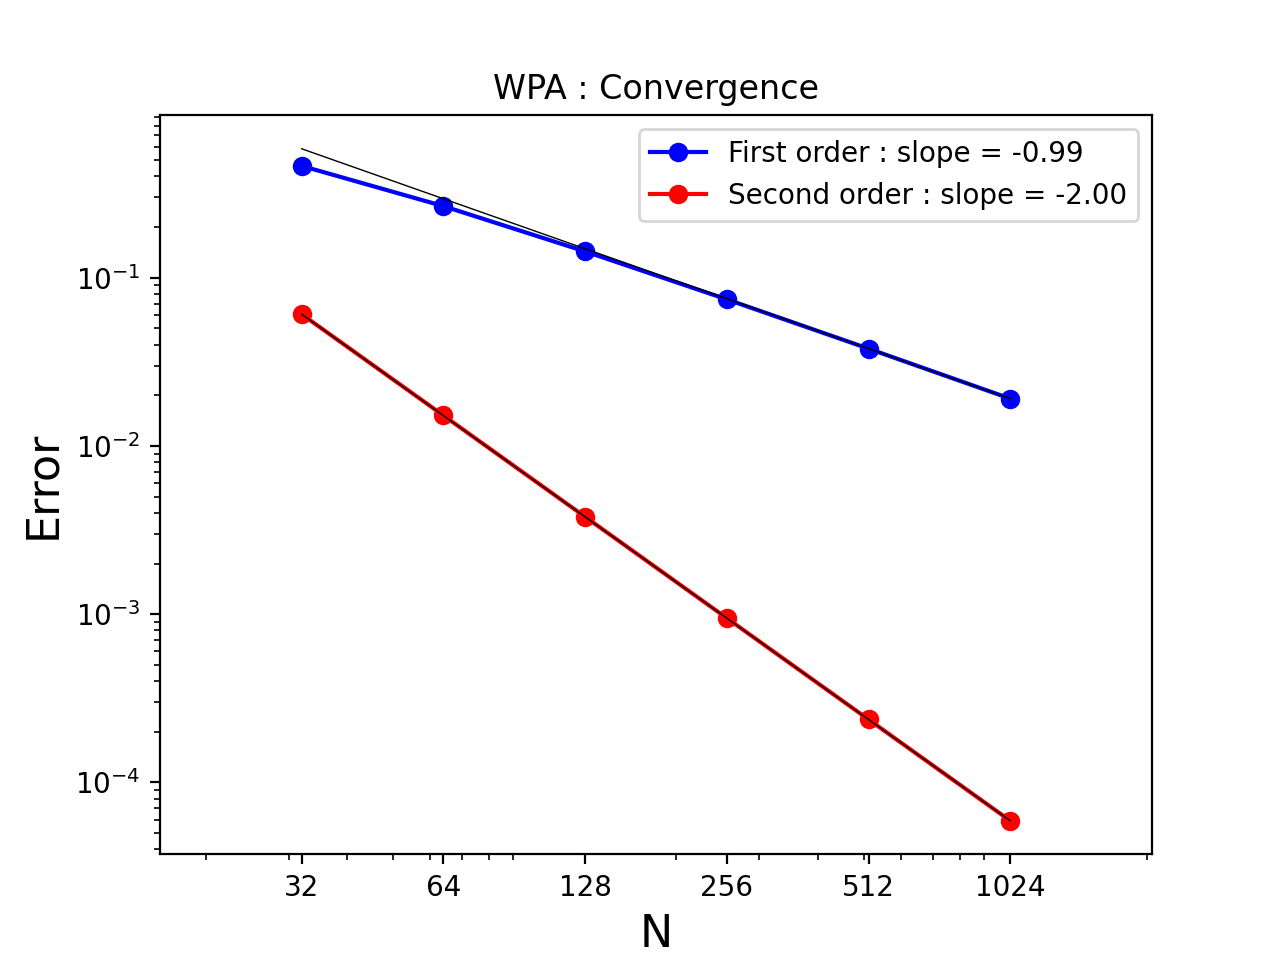

In [44]:
from cg_graphics import set_xticks

figure(2)
clf()

p = polyfit(log(Nv[4:]),log(error[4:,0]),1)
loglog(Nv,error[:,0],'b.-',markersize=12,label="First order : slope = {:.2f}".format(p[0]))
loglog(Nv,exp(polyval(p,log(Nv))),'k',linewidth=0.5)

p = polyfit(log(Nv[4:]),log(error[4:,1]),1)
loglog(Nv,error[:,1],'r.-',markersize=12,label="Second order : slope = {:.2f}".format(p[0]))
loglog(Nv,exp(polyval(p,log(Nv))),'k',linewidth=0.5)

set_xticks(Nv)
xlabel('N',fontsize=16)
ylabel('Error',fontsize=16)
title('WPA : Convergence')
       
legend()

show()

In [ ]:
from cg_dg_functions import *

In [ ]:
# Exact solution
def initial_condition(x, case):
    
    '''
    This function compute the initial condition
    
    Inputs:
    -------
            x: variable
            case: 1 for Gaussain, 2 for sinusoidal function
            
    Output:
    -------
           return the initial condition according to the case
    '''
    
    if (case == 1):
        return exp(-128*x**2)
    elif(case == 2):
        return sin(2*pi*x)
    
    return qinit

    
#time stuff
def time_step(dx, ax, bx, CFL, nel0, N, u, time_final, fixed_dt):
    
    if (fixed_dt == True):
        dx0 = (bx-ax)/(nel0*N)
        dtest = CFL*dx0/abs(u)
        ntime0 = int(time_final//dtest) + 1   # Number of time steps
        dt0 = time_final/ntime0

        f = log2(dx0/dx)
        dt = dt0/2**f
        ntime = int(ntime0*2**f)
        print('ntime = {:d}'.format(ntime))
    else:        
        dtest = CFL*dx/abs(u)
        ntime = int(time_final/dtest) + 1    # Number of time steps
        dt = time_final/ntime
        print('ntime = {:d}'.format(ntime))
        
    return dt, ntime

In [ ]:
poly_order = array([1,2])       # polynomial order
#N_element = array([10,20])  # number of elements
N_element = array([32,64,128,256,512,1024,2048])
kstages = 4               # RK2, RK3, RK4
dt = 1e-2                 # time-step, fraction of one revolution
CFL = 0.5                # CFL number
time_final = 1.0        # final time in revolutions
integration_type = 1      # %=1 is inexact and =2 is exact
method_type = 'dg'        # CG or DG
iplot = False             # plot the solution
icase = 2                 # case number: 0 is a Gaussian, 1 is a sinusoidal, ...
diss = 0 
u = 2
ax = -1
bx = 1
ntime = time_final/dt;
l2_norm = zeros((len(poly_order), len(N_element)))
Np_array = zeros((len(poly_order), len(N_element)))

nel0 = N_element[0]
Prep = []
Integ = []

for iN in range(len(poly_order)):
    N = poly_order[iN]
    if (integration_type == 1):
        Q = N
    elif (integration_type == 2):
        Q = N+1
    for e in range(len(N_element)):
        nel = N_element[e]
        
        if (method_type == 'cg'):
            Np = nel*N + 1
        elif (method_type == 'dg'):
            Np = nel*(N+1)
        
        Np_array[iN,e] = Np
        
        #dx1 = (bx-ax)/(Np-1)
        #dt1, ntime1 = time_step(dx1, ax, bx, CFL, nel0, N, u, time_final, fixed_dt = False)
        # Call of 1D wave solver
        '''
        outputs:
        --------
        qexact         : Exact solution
        q              : Computed solution
        coord          : All grid points
        intma          : Intma(CG/DG)
        '''
        qexact, q, coord, intma, t_list = cg_dgSolver(N, Q, nel, Np, ax, bx, integration_type, method_type,\
                                icase,diss,u, CFL, time_final, kstages, initial_condition)
        
        # compuation time 
        Prep.append(t_list[0])
        Integ.append(t_list[1])
        
        # Compute L2- norm
        num = 0
        denom = 0
        #error = zeros((Np, Np))
        for i in range(Np):
            num = num + (q[i]-qexact[i])**2
            #error[i] = q[i]-qexact[i]
            denom = denom + (qexact[i])**2

        l2_norm[iN,e] = sqrt(num/denom)
        
        #Compute a gridpoint solution
        x_sol = zeros(Np);
        for ie in range(1,nel+1):
            for i in range(Q):
                ip = int(intma[i,ie-1])
                x_sol[ip] = coord[i,ie-1]
    
        if(iplot == True):
            figure(iN)
            plot(x_sol, qexact)
            plot(x_sol, q, '--')
            
time_list = array([Prep, Integ, array(Prep)+array(Integ)])

In [ ]:
import pandas as pd
# error for DG
error_dg = pd.DataFrame(data = l2_norm, index = ["N = 1", "N = 2"], columns = N_element)
error_dg

In [ ]:
import cg_graphics
figure(3)
clf()
P = []   

# convergence plot for DG
for i in range(len(poly_order)):
    N = poly_order[i]
    Nvn = N_element
    if(N == 6):
        p = polyfit(log(Nvn[:3]), log(l2_norm[i][:3]), 1)
    else:
        p = polyfit(log(Nvn), log(l2_norm[i]), 1)
        
    P.append(p[0])
    loglog(Nvn, l2_norm[i], '-*',markersize=8, label ="N = {:d}: slope = {:.2f} ({:s})".format(N,p[0],method_type.upper()))
    
    loglog(Nvn, exp(polyval(p,log(Nvn))), '--')
    
# convergence plot for WPA     
p = polyfit(log(Nv[4:]),log(error[4:,0]),1)
loglog(Nv,error[:,0],'b.-',markersize=12,label="First order : slope = {:.2f}".format(p[0]))
loglog(Nv,exp(polyval(p,log(Nv))),'k',linewidth=0.5)

p = polyfit(log(Nv[4:]),log(error[4:,1]),1)
loglog(Nv,error[:,1],'r.-',markersize=12,label="Second order : slope = {:.2f}".format(p[0]))
loglog(Nv,exp(polyval(p,log(Nv))),'k',linewidth=0.5)
    
cg_graphics.set_xticks(Nv)
xlabel('#Element',fontsize=16)
ylabel('Error',fontsize=16)
title('Convergence: {:s} and {:s} methods'.format(method_type.upper(), "WPA"))
grid(axis='both',linestyle='--')
legend()
show()   

In [ ]:
# Exact integration time
header = pd.MultiIndex.from_product([poly_order, N_element], names = ['N','Nv'])
time_exact = pd.DataFrame(time_list, index = ['Prep','Integ','Global'], columns = header)

time_exact

In [ ]:
# wpa integration time
header = pd.MultiIndex.from_product([Nv], names = ['Nv'])
time_WPA = pd.DataFrame(twpa_time, index = ['First','Second'], columns = header)

time_WPA

In [ ]:
figure(4)
tglobalE = time_exact.loc["Global"]

for i in poly_order:
    
    semilogy(N_element, tglobalE[i], '.-', markersize=10, label = 'Global (DG): N = {:d}'.format(i))
    
semilogy(Nv, time_WPA.loc["First"], '*-', markersize=10, label = "First order (WPA)")
semilogy(Nv, time_WPA.loc["Second"], '*-', markersize=10, label = "Second order (WPA)")

xlabel('#Elements')
ylabel('Global time')
title("Global time vs number of elements")
legend()
show()